# 0. Introduction: goal of our analysis

* Bombini Nicola 5106823
* Iania Leonardo 5109216

Starting from the [UTK Face dataset](https://susanqq.github.io/UTKFace/), we focused on two different features of each observation: age and ethnicity:

1. For the former, we performed a sequential neural network containing convolutional layers which gives as output a scalar. This value is used to predict the age.
2. For the latter, we used again CNNs to classify the ethnicity of each observation

In pursuing our goal, we used Pytorch and d2l APIs and the project is based on the Deep Learning course taught from professor Jianyi Lin @ Università Cattolica del Sacro Cuore in Milan.

In [ ]:
%%capture 
# libraries
!pip install d2l==1.0.0a1.post0
!pip install split-folders

import os, os.path, shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import splitfolders
from sklearn.metrics import confusion_matrix
import warnings
from google.colab import drive
drive.mount('/content/drive')
sns.set_theme();
d2l.use_svg_display()
%matplotlib inline

# 1. Data Exploration

The [original dataset](https://susanqq.github.io/UTKFace/) is made of 23708 pictures of people in the age range 0-116 and five different ethnicities: White, Black, Asian, Indian, and Others (like Hispanic or Latino). 

For each picture age is the first element of the file name and ethnicity is the third one, and since 3 images didn't contain the ethnicity, we decided to delete them, reducing the data from 23708 to 23705.

We start by unpacking our data:

In [ ]:
# data reading for ethnicity 
%%capture

!tar -xzvf "/content/drive/MyDrive/progetto_dl/Dire2.tar.gz" -C "/content/" 

folder_path = "/content/Dire/UTKFace/"

images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for image in images:
    folder_name = image.split('_')[2]

    new_path = os.path.join(folder_path, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

Let's see 5 pictures - each representing a different ethnicity:

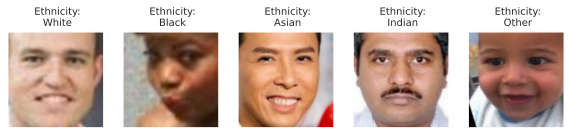

In [ ]:
# plot 1 picture for each ethnicity
etn_name_xplot = ['White', 'Black', 'Asian', 'Indian', 'Other']
plt.figure(figsize=(10,6))

for j in range(5):
  plt.subplot(1,5,j+1)
  readable = os.listdir('/content/Dire/UTKFace/'+str(j))[0]
  readable = '/content/Dire/UTKFace/'+str(j)+'/'+readable
  image = imread(readable)
  plt.title(f'  Ethnicity: \n {etn_name_xplot[j]}', fontsize=10)
  plt.xticks([]) 
  plt.yticks([])
  plt.imshow(image)

It's worth mentioning that in the 'Other' category, we have an heterogeneous set of ethnicities, like:
* Hispanic
* Latino
* Middle Eastern

Since what follows is a classification task, we need to check how represented are the categories we want to predict, to avoid biases in model prediction:

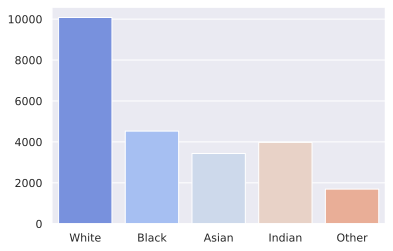

In [ ]:
# count categories size and barplot
categories_size =[]
for i in range(5):
  # folder path
  dir_path = f'/content/Dire/UTKFace/{i}'
  count = 0
  # Iterate directory
  for path in os.listdir(dir_path):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1
  categories_size.append(count)

import seaborn as sns
sns.set_theme(palette='coolwarm')
sns.barplot(y=categories_size,x=etn_name_xplot);

In [ ]:
print(f'{round((categories_size[0]/sum(categories_size))*100,2)} %')

42.51 %


Problem: about half of the dataset belongs to the first ethnicity category, white. This can lead to fake results in our model, so we decided to randomly delete half of the observations in this category to obtain well-balanced data.

In [ ]:
# code for balance
%%capture
path = '/content/Dire/UTKFace/0/'
file_name=os.listdir(path)

np.random.seed(0)
index_to_del=np.random.randint(0,10078,int(10078*0.5))
# index_to_del[0:20] will always be the same given the np seed = 0

for i in index_to_del:
  file = path + file_name[i]
  if os.path.isfile(file):
    print('Deleting file:', file)
    os.remove(file)

We then checked again the categories barplot:

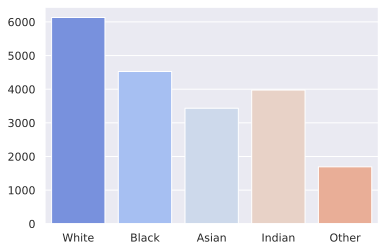

In [ ]:
# categories after balancing + bar plot:
categories_size_new =[]
for i in range(5):
  # folder path
  dir_path = f'/content/Dire/UTKFace/{i}'
  count = 0
  # Iterate over the directory
  for path in os.listdir(dir_path):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1

  categories_size_new.append(count)


import seaborn as sns

sns.set_theme(palette='coolwarm')
sns.barplot(y=categories_size_new,x=etn_name_xplot);

Now our dataset seems pretty balanced, hence we can start with the modeling part

# 2. Modeling 

Before starting, we reset the theme of the plots, to have later a better visualization of the evolution of the models:

In [ ]:
sns.reset_orig()

In order to train correctly our network, we split our data in train, validation, and test set, creating one folder for each:

In [ ]:
splitfolders.ratio("/content/Dire/UTKFace/", # The location of dataset
                   output="/content/Dire/Data_etn", # The output location
                   seed=42, # The number of seed
                   ratio=(.6, .2, .2), # The ratio of splited dataset
                   group_prefix=None,
                   move=False
                   )

Copying files: 19759 files [00:03, 5443.69 files/s]


We start the modeling part by preparing our data. We decided to resize our pictures from 200x200 to 80x80 for computational reasons and to remove possible noise around our target, then we transform our pictures to tensors to be able to process them in our network:

In [ ]:
data_augmentation = transforms.Compose([
        transforms.Resize(80),
        transforms.ToTensor() # Pytorch transforms.totensor() automatically converts images to tensor with mean=0 and sd = 1 . source: https://discuss.pytorch.org/t/does-pytorch-automatically-normalizes-image-to-0-1/40022
    ])

trainset = datasets.ImageFolder(root='/content/Dire/Data_etn/train',
                                           transform=data_augmentation)
testset = datasets.ImageFolder(root='/content/Dire/Data_etn/test',
                                           transform=data_augmentation)
valset = datasets.ImageFolder(root='/content/Dire/Data_etn/val',
                                           transform=data_augmentation)

We then define the iterator that we will use in the training of our model, with a batch size of 64:

In [ ]:
train_loader = data.DataLoader(trainset,batch_size=64, shuffle=True,num_workers=2)

Here below we define our network. We used a kind of AlexNet-like structure, since we use an alternation of convolutional and maximum pooling layers, before the fully connected part, but there are some differences:
* We decided, besides the first and the last ones, to use the same number of input and output channels in the convolutional layers
  * In all of them we kept the same 3x3 kernel, with a stride of 1, and we used no padding
* We did not use any activation function, neither in the convolutional nor linear layers
* We used one batch normalization layer between the convolution layers, and between the last ones and the maximum pooling ones
* We reduced the maximum pooling kernel to 2x2
* We used only one dropout, with the probability reduced to 25%, and we placed it after the flattening layer
* We added more linear layers, following the same logic as before

In [ ]:
etn_net = nn.Sequential(
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
nn.BatchNorm2d(16),
nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
nn.BatchNorm2d(16),
nn.MaxPool2d(2),

nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
nn.BatchNorm2d(16),
nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
nn.BatchNorm2d(16),
nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
nn.BatchNorm2d(8),

nn.MaxPool2d(2),

nn.Flatten(),
nn.Dropout(0.25),
nn.Linear(2048, 512),
nn.Linear(512, 128),
nn.Linear(128, 64),
nn.Linear(64,5),
)

Here we used the classic loss metric for classification, Cross Entropy:

In [ ]:
eth_loss = nn.CrossEntropyLoss()

We decided to use the Adam optimizer with a learning rate of 0.01:

In [ ]:
trainer = torch.optim.Adam(etn_net.parameters(), lr=0.01)

We then define the functions to train our model, for each epoch, and in general:

In [ ]:
def train_epoch(net, train_iter, loss, updater):
    """The training loop"""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, nb. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    # Model training:
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'val acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return train_loss, train_acc, test_acc

We define the validation set iterator, which we will use to evaluate our training for each epoch: 

In [ ]:
val_loader=data.DataLoader(valset,batch_size=64, shuffle=True,num_workers=2)

We then proceeded to train our model:

Loss:  0.757777897019762
Accuracy:  0.7335076767335921
Validation: 0.7331645569620253


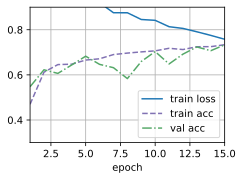

In [ ]:
num_epochs = 15
train_loss, train_acc, test_acc = train(etn_net, train_loader, val_loader, eth_loss, num_epochs, trainer)
print("Loss: ", train_loss)
print("Accuracy: ", train_acc)
print('Validation:', test_acc)

We reach an overall validation accuracy of around 73%, which we will inspect better in the next chapter

# 3. Generalization results


To better see our results, since we have many categories, with lots of difference in between them, we start by building a confusion matrix:

In [ ]:
y_pred = []
y_true = []
testloader = data.DataLoader(testset,batch_size=1024, shuffle=True,num_workers=2)
# iterate over test data
for inputs, labels in testloader:
        
        output=etn_net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('W','B','Asian','Indian','Others')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

Before diving into the single categories analysis, let's give a look at the overall test accuracy:

In [ ]:
print(f'The overall test accuracy is: {round(cf_matrix.trace()/sum(sum(cf_matrix)),3)*100}%')

The overall test accuracy is: 73.2%


The overall accuracy, as we can expect from the validation one, is around 73%.

Now we can inspect how our model performs in each category:

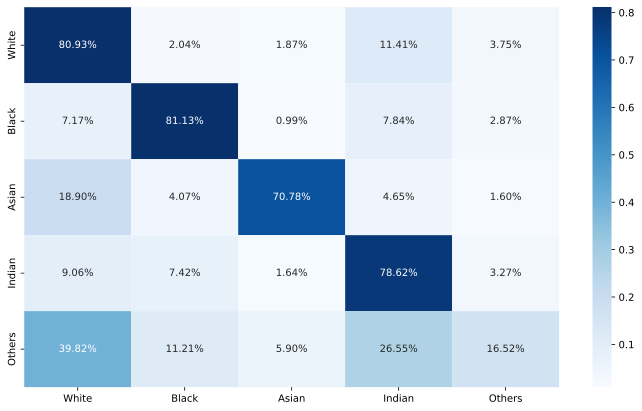

In [ ]:
# Let's count each category size

path_test_w='/content/Dire/Data_etn/test/0'
conto_w_test=0
for i in os.listdir(path_test_w):
  conto_w_test+=1 # white size

path_test_b='/content/Dire/Data_etn/test/1'
conto_b_test=0
for i in os.listdir(path_test_b):
  conto_b_test+=1 # black size

path_test_a='/content/Dire/Data_etn/test/2'
conto_a_test=0
for i in os.listdir(path_test_a):
  conto_a_test+=1 # asian size

path_test_i='/content/Dire/Data_etn/test/3'
conto_i_test=0
for i in os.listdir(path_test_i):
  conto_i_test+=1 # indian size

path_test_l='/content/Dire/Data_etn/test/4'
conto_l_test=0
for i in os.listdir(path_test_l):
  conto_l_test+=1 # others size

# then we can calculate the recall ( TP/(TP+FP) ) row by row:

# True white row:
w_row=cf_matrix[0]/conto_w_test
# True black row:
b_row=cf_matrix[1]/conto_b_test
# True asian row:
a_row=cf_matrix[2]/conto_a_test
# True indian row:
i_row=cf_matrix[3]/conto_i_test
# True "others" row:
l_row=cf_matrix[4]/conto_l_test

np.set_printoptions(suppress=True) # used to avoid scientific notation
rel_m = np.array((w_row,b_row,a_row,i_row,l_row)) # we put together the rows
rel_m=np.around(rel_m,4)

plt.figure(figsize = (12,7))
labels=['White','Black','Asian','Indian','Others']
df_rel_m= pd.DataFrame(rel_m,index = labels,columns = labels)
sns.heatmap(df_rel_m, annot=True,fmt='.2%', cmap='Blues');

As we can see from the confusion matrix, we actually achieve a good performance with four out of the five categories. In fact the only bad performing one is the "Others", as could expect since it is a mixture of different ethnicities and it was even the smallest group of all.

Another interesting way to evaluate our performance is by seeing some pictures from the test set and compare the true and the predicted ethnicity:

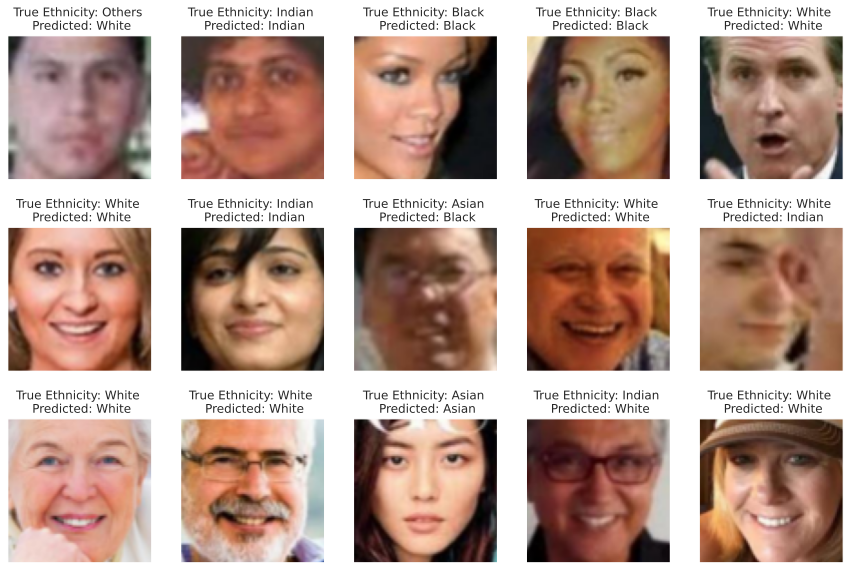

In [ ]:
for X, y in testloader:
        break

labels=['White','Black','Asian','Indian','Others']
np.random.seed(9)
toplot_etn = np.random.randint(0,len(X),15)
count=1
s_m = nn.Softmax()

import warnings
warnings.filterwarnings("ignore")

sns.set_theme();
plt.figure(figsize=(15,10))
for i in toplot_etn:
  plt.subplot(3,5,count)
  im = transforms.ToPILImage()(X[i]).convert("RGB")
  pred_vector = s_m(etn_net(X[i].reshape(1,3,80,80)))
  predicted = int(torch.argmax(pred_vector))
  plt.imshow(im)
  plt.title(f'True Ethnicity: {labels[int(y[i])]} \n Predicted: {labels[predicted]}')
  plt.xticks([])
  plt.yticks([])
  count += 1

plt.show();

# 4. Conclusion

From our results, we can state that the model is quite well performing, and we can also say that without the "Others" category we would have surely reached an higher overall accuracy, since this category contributes in creating confusion in network training